In [1]:
from datetime import datetime, date
import math
import os
import warnings

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import scipy
from statsmodels.nonparametric.smoothers_lowess import lowess
from IPython.display import display, Markdown, Latex

from qaoa_solver import QAOASolver
from utils import int_to_binary_str, compute_solution, compute_fidelity


pd.set_option('display.max_columns', None)

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
experiment_names = os.listdir('experiments/results')
experiment_names = [name for name in experiment_names if not name.startswith('test')]
experiment_results = []

for experiment in experiment_names:

    experiment_result_files = os.listdir(f'experiments/results/{experiment}')
    
    for result_file in experiment_result_files:
        result_date = datetime.strptime(result_file.split('_')[-1].split('.json')[0], '%Y%m%d%H%M%S%f').date()
        result = pd.read_json(f'experiments/results/{experiment}/{result_file}',lines=True)
        result['date'] = result_date
        experiment_results.append(result)


experiment_results = pd.concat(experiment_results)
experiment_results['num_qubits'] = experiment_results['nx'] + experiment_results['ny']
experiment_results['optimizer'] = experiment_results['config'].apply(lambda c: c.get('optimizer'))
experiment_results['problem_hamiltonian'] = experiment_results['config'].apply(lambda c: c.get('problem_hamiltonian'))
experiment_results['cost_hamiltonian'] = experiment_results['config'].apply(lambda c: c.get('cost_hamiltonian'))
experiment_results['gamma_0'] = experiment_results['config'].apply(lambda c: c.get('initial_gamma'))
experiment_results['beta_0'] = experiment_results['config'].apply(lambda c: c.get('initial_beta'))
experiment_results['experiment'] = experiment_results['config'].apply(lambda c: c.get('experiment'))
experiment_results['extended_qaoa'] = experiment_results['config'].apply(lambda c: c.get('extended_qaoa', False))
experiment_results['max_layers'] = experiment_results['config'].apply(lambda c: c.get('layers'))
experiment_results['commit_date'] = pd.to_datetime(experiment_results['config'].apply(lambda c: c.get('commit_date')))
experiment_results['setup'] = experiment_results['experiment'].str.split('_').str[1:].str.join('_')
experiment_results['state_populations'] = experiment_results['state'].apply(lambda s: [abs(complex(c))**2 for c in s])
experiment_results['solution'] = experiment_results.apply(lambda row: compute_solution(row['N']), axis=1)
experiment_results['fidelity'] = experiment_results.apply(lambda row: compute_fidelity(row['state_populations'], row['solution']), axis=1)

experiment_results = experiment_results[(experiment_results['extended_qaoa']==False)]

In [3]:
Ns = sorted(experiment_results['N'].unique())
cost_Hs = sorted(experiment_results['cost_hamiltonian'].unique())

dfs = []

for N in Ns:
    for Hc in cost_Hs:
        solver = QAOASolver(N=N, cost_hamiltonian=Hc)
        Ec = [E.real for E in solver.Ec]
        df = pd.DataFrame({
            'N': [N],
            'cost_hamiltonian': [Hc],
            'Ec': [Ec]
        })
        dfs.append(df)

energies_df = pd.concat(dfs, ignore_index=True)

experiment_results = experiment_results.merge(energies_df, how='left', on=['N', 'cost_hamiltonian'])
experiment_results['energy_max'] = experiment_results['Ec'].apply(lambda E: np.max(E))
experiment_results['energy_norm'] = experiment_results['Ec'].apply(lambda E: np.linalg.norm(E))
experiment_results['energy_avg'] = experiment_results['Ec'].apply(lambda E: np.average(E))

max_costs = experiment_results.groupby(['N', 'optimizer', 'setup'])['cost'].max().reset_index()
max_costs = max_costs.rename(columns={'cost': 'max_cost'})
experiment_results = experiment_results.merge(max_costs, how='left', on=['N', 'optimizer', 'setup'])
experiment_results['cost_rescaled'] = experiment_results['cost'] / experiment_results['max_cost']

In [4]:
plot_colors = [
    #[Dark ,    light]
    ["black",   "#A0A0A0"],  # Black
    ["#004C99", "#99CCFF"],  # Blue
    ["#990000", "#FF9999"],  # Red
    ["#006633", "#CCFFCC"],  # Green
    ["#b8860b", "#ffd700"],  # Golden
    ["#cc4c02", "#fe9929"],  # Orange
    ["#a10694", "#c994c7"],  # Purple
    ["#8c510a", "#d8b365"],  # Brown
    ["#0868ac", "#43a2ca"],  # Cian
]

## Comparison between optimizers (N = 15)

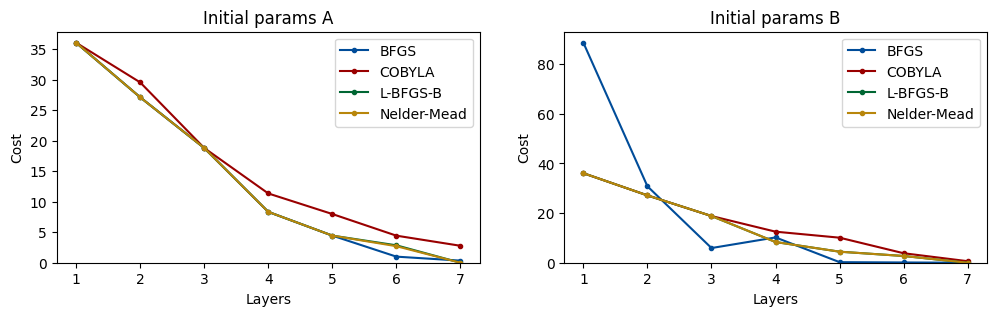

In [5]:
df = experiment_results[(experiment_results['N']==15) & (experiment_results['setup']=='standard')]
df = df.rename(columns={'optimizer_success': 'opt_succ'})

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))

for j, optimizer in enumerate(sorted(df['optimizer'].unique())):
    df_opt = df[(df.optimizer == optimizer)]

    df_a = df_opt[df_opt['gamma_0'].round(5)==0.00557]
    axs[0].set_title('Initial params A')
    axs[0].plot('layers', 'cost', data=df_a, marker='.', color=plot_colors[j+1][0], label=optimizer)

    df_b = df_opt[df_opt['gamma_0'].round(5)==0.00058]
    axs[1].set_title('Initial params B')
    axs[1].plot('layers', 'cost', data=df_b, marker='.', color=plot_colors[j+1][0], label=optimizer)

for ax in axs:
    ax.set_ylabel('Cost')
    ax.set_xlabel('Layers')
    ax.set_ylim(0)
    ax.legend(loc='best')

* L-BFGS-B is the best overall optimizer among the tested methods.
* Nelder-Mead's performance is similar to L-BFGS-B, but it is in the limit of scalability.
* COBYLA has a good performance as long as a huge amount of steps are allowed, making it the
slowest of the tested methods. Even with that, the optimizer finds difficulties to succeed in
multiple occasions. It doesn't seem very appropriate for our problem.
* Since BFGS is unbounded, it is the least predictable method due to the QAOA periodic nature: $\exp (i \gamma H)$.
Interestingly, BFGS found better solutions than L-BFGS-B for some layers and converged to the problem's solution. It is sensitive to initial conditions.

## Standard protocol

### Preliminar analysis

In [6]:
solver = QAOASolver(39)

# Max angle
max_gamma = 2*np.pi/max(solver.Ep)
print(max_gamma)

0.0014424208694168012


**Optimal $\gamma$ for a given $\beta$**

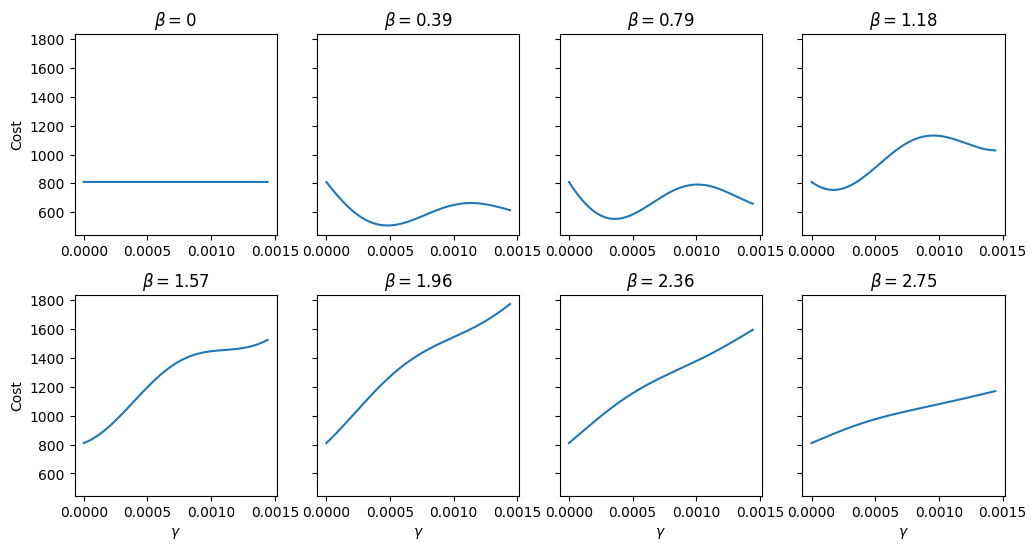

In [7]:
gammas = np.linspace(0, max_gamma, 10000)
betas = [0, np.pi/8, 2*np.pi/8, 3*np.pi/8, 4*np.pi/8, 5*np.pi/8, 6*np.pi/8, 7*np.pi/8]

fig, axs = plt.subplots(2, 4, figsize=(12,6), sharey=True, sharex=False)
axs = axs.flatten()
fig.subplots_adjust(hspace=0.3)

for i, beta in enumerate(betas):
    cost = []

    for gamma in gammas:
        res = solver._compute_cost([gamma, beta])
        cost.append(res)

    df = pd.DataFrame({'gamma': gammas, 'cost': cost})

    
    axs[i].plot('gamma', 'cost', data=df)
    axs[i].set_title(f'$\\beta = {round(beta, 2)}$')
    if i in [0,4]:
        axs[i].set_ylabel('Cost')
    if i > 3:
        axs[i].set_xlabel('$\\gamma$')

**Optimal $\beta$ for a given $\gamma$**

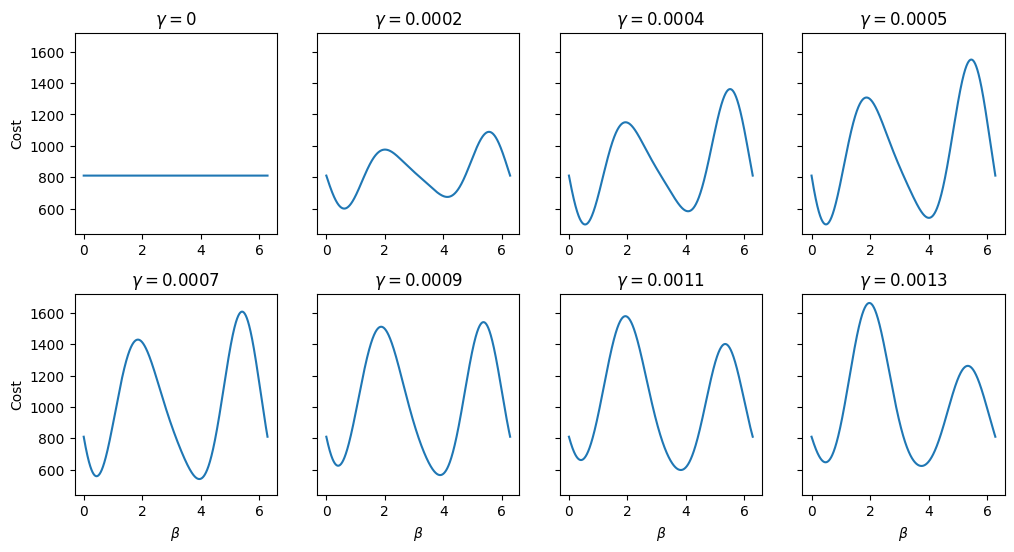

In [8]:
betas = np.linspace(0, 2*np.pi, 10000)
gammas = [0, max_gamma/8, 2*max_gamma/8, 3*max_gamma/8, 4*max_gamma/8, 5*max_gamma/8, 6*max_gamma/8, 7*max_gamma/8]

fig, axs = plt.subplots(2, 4, figsize=(12,6), sharey=True, sharex=False)
axs = axs.flatten()
fig.subplots_adjust(hspace=0.3)

for i, gamma in enumerate(gammas):
    cost = []

    for beta in betas:
        res = solver._compute_cost([gamma, beta])
        cost.append(res)

    df = pd.DataFrame({'beta': betas, 'cost': cost})

    
    axs[i].plot('beta', 'cost', data=df)
    axs[i].set_title(f'$\\gamma = {round(gamma, 4)}$')
    if i in [0,4]:
        axs[i].set_ylabel('Cost')
    if i > 3:
        axs[i].set_xlabel('$\\beta$')

### Individual experiments

**1. Minimum for one layer QAOA**

,N,layers,gamma_0,beta_0,gammas,betas,cost,fidelity
540,39,1,0.0004,0.0,[0.0004457753396],[0.524479454685708],488.233997,0.045932
180,39,1,0.0004,0.5,[0.00044577566782],[0.524478701152508],488.233997,0.045932
74,39,1,0.0004,1.0,[0.00044577562479700003],[0.524478621294845],488.233997,0.045932
330,39,1,0.0004,1.5,[0.0],[0.0],810.000000,0.031250


**2. State at layers=50**

,N,layers,gamma_0,beta_0,cost,fidelity
589,39,50,0.0004,0.0,15.623115,0.333477
229,39,50,0.0004,0.5,16.082192,0.330780
123,39,50,0.0004,1.0,15.460285,0.329812
379,39,50,0.0004,1.5,810.000000,0.031250


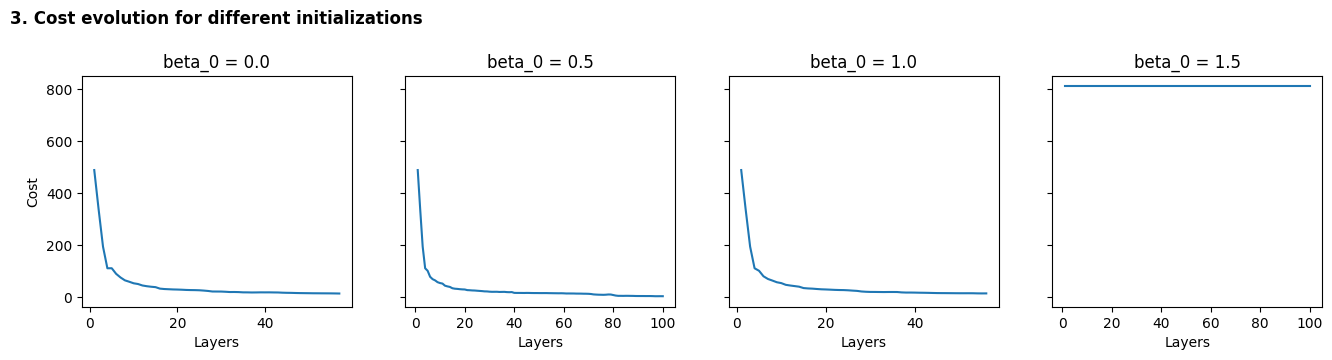

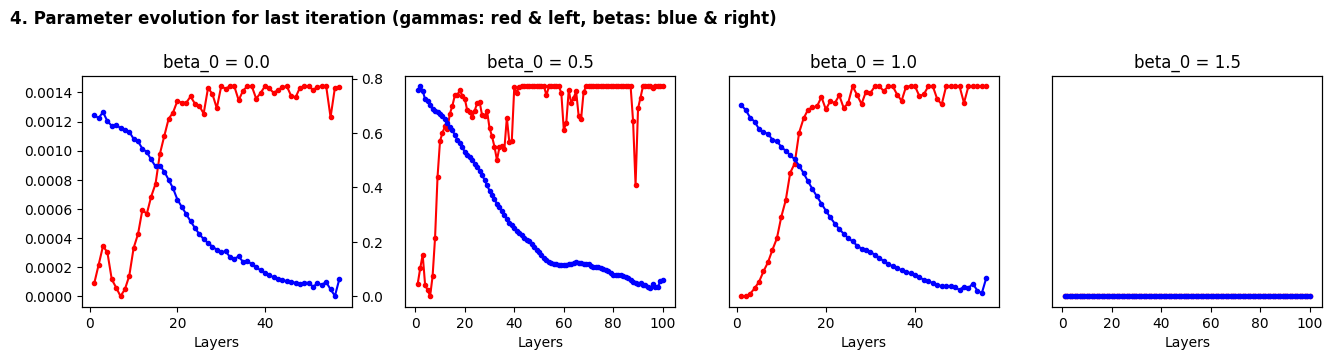

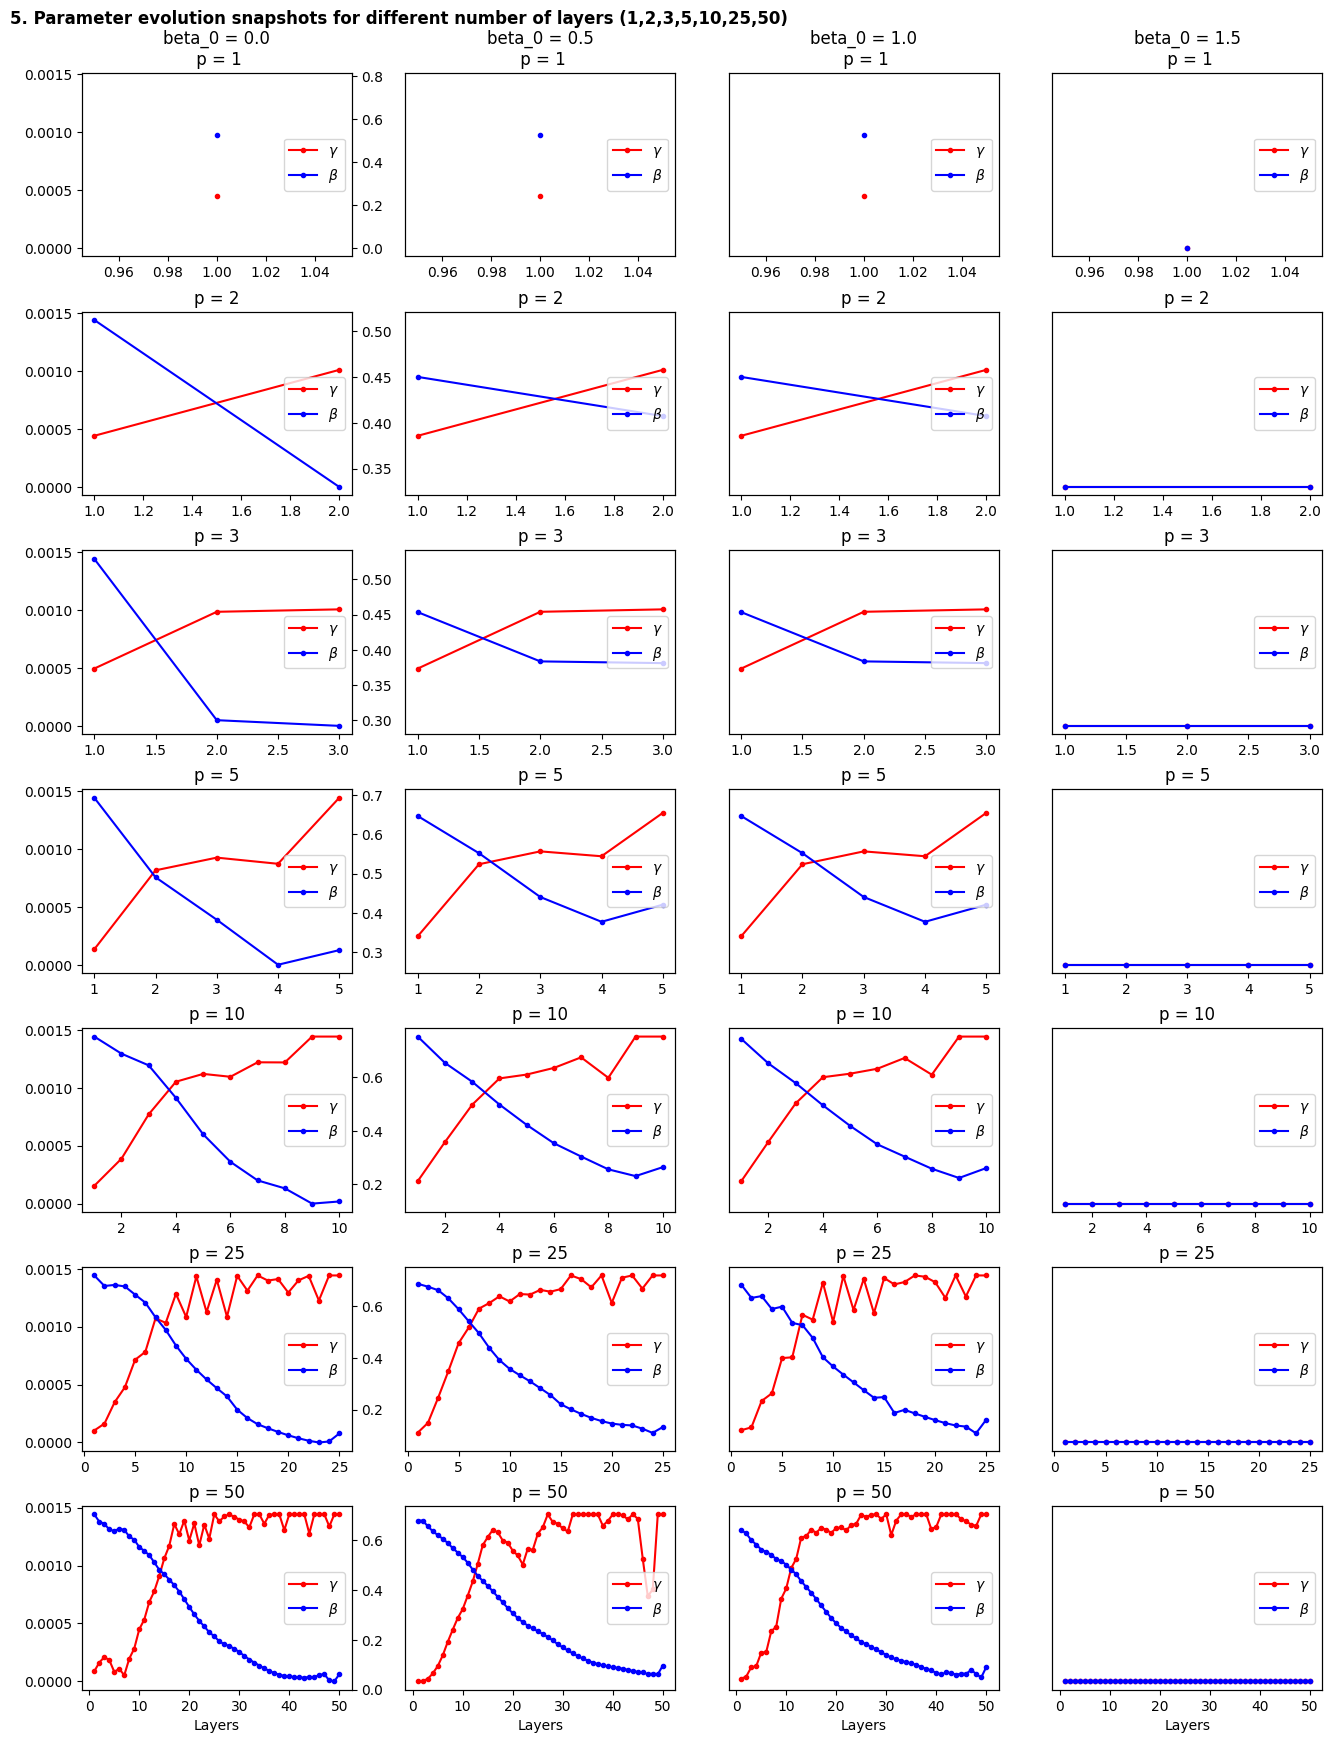

In [9]:
N = 39
gamma_0 = 0.0004

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='standard')
                        & (experiment_results['optimizer']=='L-BFGS-B')
                        & (experiment_results['gamma_0']==gamma_0)]

init_betas = sorted(df['beta_0'].unique())

display(Markdown("**1. Minimum for one layer QAOA**"))
display(df[df['layers']==1][['N', 'layers', 'gamma_0', 'beta_0', 'gammas', 'betas', 'cost', 'fidelity']].sort_values('beta_0'))

display(Markdown("**2. State at layers=50**"))
display(df[df['layers']==50][['N', 'layers', 'gamma_0', 'beta_0', 'cost', 'fidelity']].sort_values('beta_0'))

fig, axs = plt.subplots(1, len(init_betas), figsize=(16, 3), sharey=True)
fig.suptitle("3. Cost evolution for different initializations", x=0.08, y=1.1, ha='left', fontweight='bold')
for i, beta_0 in enumerate(init_betas):
    df_i = df[df['beta_0']==beta_0]
    axs[i].plot('layers', 'cost', data=df_i)
    axs[i].set_xlabel('Layers')
    axs[i].set_title(f'beta_0 = {beta_0}')

    if i==0:
        axs[i].set_ylabel('Cost')


fig, axs = plt.subplots(1, len(init_betas), figsize=(16, 3), sharey='row')
sec_axs = [ax.twinx() for ax in axs]
fig.suptitle("4. Parameter evolution for last iteration (gammas: red & left, betas: blue & right)", x=0.08, y=1.1, ha='left', fontweight='bold')
for i, beta_0 in enumerate(init_betas):
    df_i = df[df['beta_0']==beta_0].reset_index()
    max_layer_idx = df_i['layers'].idxmax()
    max_layer = df_i.loc[max_layer_idx, 'layers']
    gammas = df_i.loc[max_layer_idx, 'gammas']
    betas = df_i.loc[max_layer_idx, 'betas']
    axs[i].plot(range(1, max_layer+1), gammas, marker='.', color='red')
    sec_axs[i].plot(range(1, max_layer+1), betas, marker='.', color='blue')
    axs[i].set_xlabel('Layers')
    axs[i].set_title(f'beta_0 = {beta_0}')

    if i>0:
        sec_axs[i].sharey(sec_axs[0])
        axs[i].get_yaxis().set_visible(False)
        sec_axs[i].get_yaxis().set_visible(False)



samples = [1,2,3,5,10,25,50]
fig, axs = plt.subplots(len(samples), len(init_betas), figsize=(16, 3*len(samples)), sharey=True)
fig.subplots_adjust(wspace=0.2, hspace=0.3)
sec_axs = np.empty_like(axs, dtype=object)
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        sec_axs[i, j] = axs[i, j].twinx()
fig.suptitle("5. Parameter evolution snapshots for different number of layers (1,2,3,5,10,25,50)", x=0.08, y=0.91, ha='left', fontweight='bold')
for idx_row, p in enumerate(samples):
    for idx_col, beta_0 in enumerate(init_betas):
        df_i = df[(df['beta_0']==beta_0) & (df['layers']==p)].reset_index()
        if not df_i.empty:
            gammas = df_i.loc[0, 'gammas']
            betas = df_i.loc[0, 'betas']
            axs[idx_row][idx_col].plot(range(1, len(gammas)+1), gammas, marker='.', color='red', label='$\\gamma$')
            sec_axs[idx_row][idx_col].plot(range(1, len(betas)+1), betas, marker='.', color='blue', label='$\\beta$')
            if idx_row==0:
                axs[idx_row][idx_col].set_title(f'beta_0 = {beta_0}\n p = {p}')
            else:
                axs[idx_row][idx_col].set_title(f'p = {p}')
            if idx_row==len(samples) - 1:
                axs[idx_row][idx_col].set_xlabel('Layers')
            if idx_col>0:
                axs[idx_row][idx_col].get_yaxis().set_visible(False)
                sec_axs[idx_row][idx_col].get_yaxis().set_visible(False)
                sec_axs[idx_row][idx_col].sharey(sec_axs[0][0])
            
            lines, labels = axs[idx_row][idx_col].get_legend_handles_labels()
            lines2, labels2 = sec_axs[idx_row][idx_col].get_legend_handles_labels()
            sec_axs[idx_row][idx_col].legend(lines + lines2, labels + labels2, loc='center right')

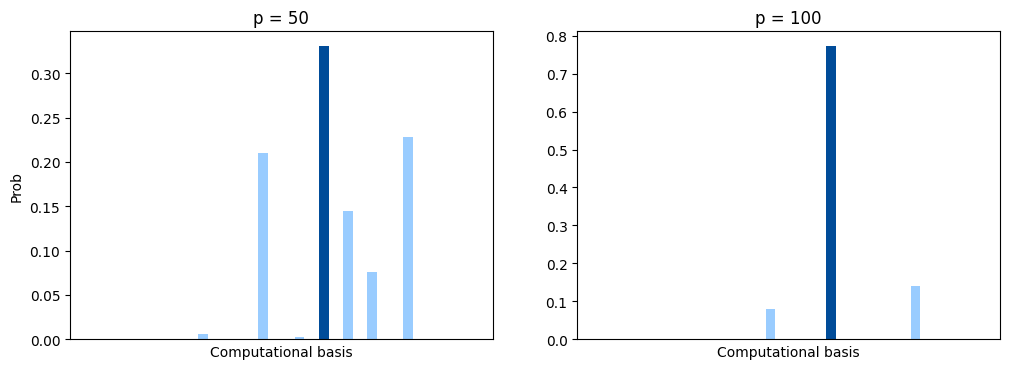

In [10]:
N = 39
gamma_0 = 0.0004
beta_0 = 0.5

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='standard')
                        & (experiment_results['optimizer']=='L-BFGS-B')
                        & (experiment_results['gamma_0']==gamma_0)
                        & (experiment_results['beta_0']==beta_0)].reset_index(drop=True)

num_qubits = df.loc[0, 'num_qubits']
solutions = compute_solution(N)
x_hist = [int_to_binary_str(n, num_qubits) for n in range(2**num_qubits)]
bar_colors = [plot_colors[1][0] if c in solutions else plot_colors[1][1] for c in x_hist]

pops_50 =  df[df['layers']==50].reset_index().loc[0, 'state_populations']
pops_100 =  df[df['layers']==100].reset_index().loc[0, 'state_populations']

fig, axs = plt.subplots(1,2, figsize=(12,4))

axs[0].bar(x_hist, pops_50, color=bar_colors)
axs[1].bar(x_hist, pops_100, color=bar_colors)
axs[0].set_ylabel('Prob')
axs[0].set_xlabel('Computational basis')
axs[1].set_xlabel('Computational basis')

axs[0].set_xticks(range(2**num_qubits), "")
axs[0].xaxis.set_major_locator(ticker.NullLocator())
axs[0].set_title('p = 50')
axs[1].set_xticks(range(2**num_qubits), "")
axs[1].xaxis.set_major_locator(ticker.NullLocator())
axs[1].set_title('p = 100');

### N=39, 100 layers

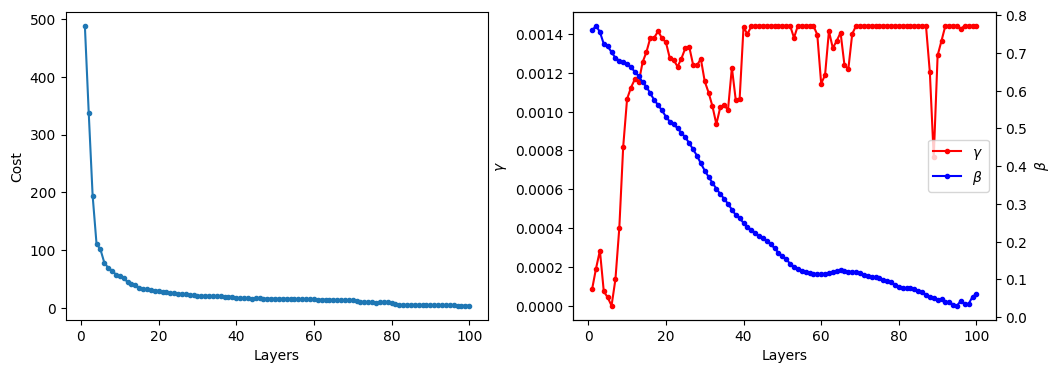

In [11]:
N = 39
gamma_0 = 0.0004
beta_0 = 0.5

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='standard')
                        & (experiment_results['optimizer']=='L-BFGS-B')
                        & (experiment_results['gamma_0']==gamma_0)
                        & (experiment_results['beta_0']==beta_0)]

fig, axs = plt.subplots(1,2, figsize=(12,4))
axs[0].plot('layers', 'cost', data=df, marker='.')
axs[0].set_xlabel('Layers')
axs[0].set_ylabel('Cost')

max_layers = df['layers'].max()
gammas = df[df['layers'] == max_layers].reset_index().loc[0, 'gammas']
betas = df[df['layers'] == max_layers].reset_index().loc[0, 'betas']
sec_ax = axs[1].twinx()
axs[1].plot(range(1, max_layers+1), gammas, marker='.', color='red', label='$\\gamma$')
sec_ax.plot(range(1, max_layers+1), betas, marker='.', color='blue', label='$\\beta$')
axs[1].set_xlabel('Layers')
axs[1].set_ylabel('$\\gamma$')
sec_ax.set_ylabel('$\\beta$')

lines, labels = axs[1].get_legend_handles_labels()
lines2, labels2 = sec_ax.get_legend_handles_labels()
sec_ax.legend(lines + lines2, labels + labels2, loc='center right');


### Comparing with an unbounded method (BFGS)

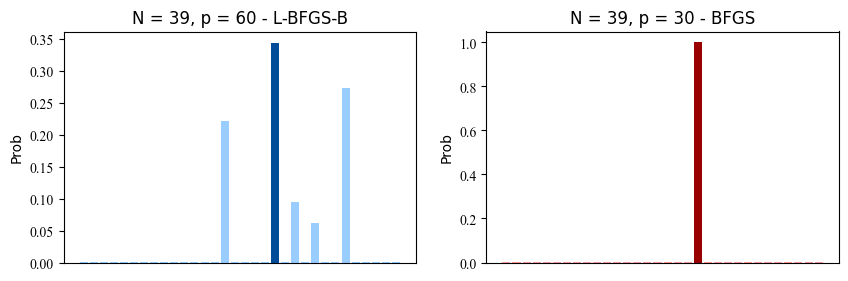

In [12]:
N = 39
gamma_0 = 0.0005
beta_0 = 0.4

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='standard')
                        & (experiment_results['gamma_0']==gamma_0)
                        & (experiment_results['beta_0']==beta_0)].reset_index(drop=True)
fig, axs = plt.subplots(1, 2, figsize=(10,3))

for j, optimizer in enumerate(['L-BFGS-B', 'BFGS']):
    df_j = df[df['optimizer']==optimizer].reset_index()
    idx_last_layer = df_j['layers'].idxmax()
    num_qubits = df_j.loc[idx_last_layer, 'num_qubits']
    solutions = compute_solution(N)
    x_hist = [int_to_binary_str(n, num_qubits) for n in range(2**num_qubits)]

    pops =  df_j.loc[idx_last_layer, 'state_populations']

    bar_colors = [plot_colors[j+1][0] if c in solutions else plot_colors[j+1][1] for c in x_hist]

    axs[j].bar(x_hist, pops, color=bar_colors)
    axs[j].set_ylim(0)
    axs[j].set_ylabel('Prob')

    labels = (axs[j].get_xticklabels() + axs[j].get_yticklabels())

    for label in labels:
        label.set_fontname('Times New Roman')

    axs[j].set_xticks(range(2**num_qubits), "")
    axs[j].xaxis.set_major_locator(ticker.NullLocator())
    p = df_j.loc[idx_last_layer, 'layers']
    axs[j].set_title(f'N = {N}, p = {p} - {optimizer}')

    if i == len(Ns)-1:
        axs[j].set_xlabel('Computational basis')

### All numbers

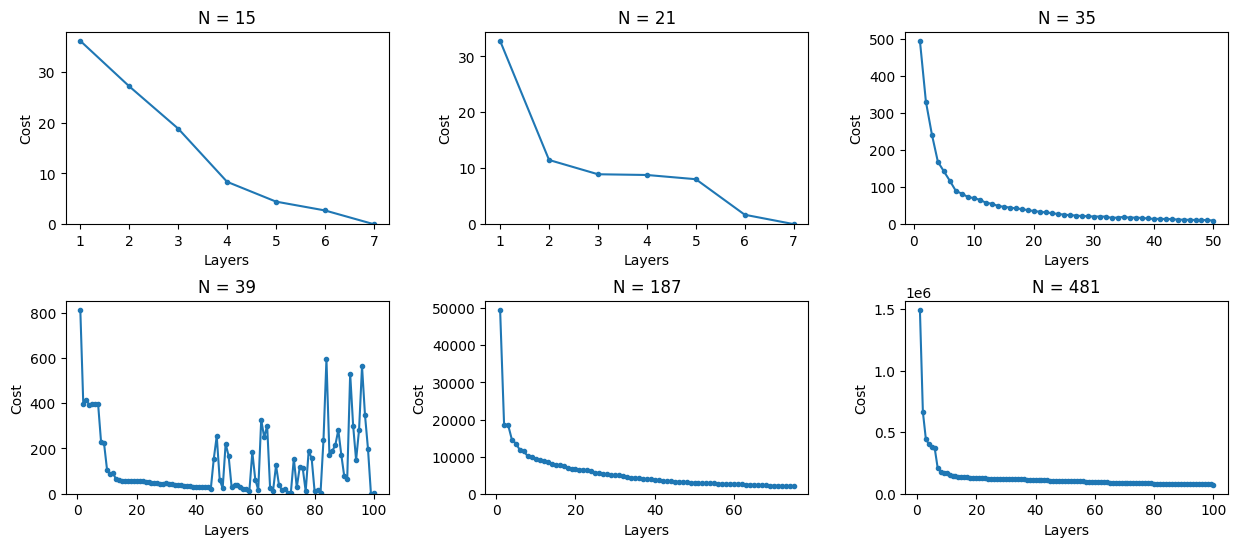

In [13]:
df = experiment_results[(experiment_results['setup']=='standard')
                        & (experiment_results['optimizer']=='L-BFGS-B')]
df = df.groupby(['N','layers']).last().reset_index()

Ns = sorted(df['N'].unique())
optimizers = sorted(experiment_results['optimizer'].unique())
setups = sorted(experiment_results['setup'].unique(), reverse=True)

ncols = 3
nrows = math.ceil(len(Ns) / ncols)
fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols,3*nrows))
fig.subplots_adjust(hspace=0.4, wspace=0.3)
axs = axs.flatten()
for i, N in enumerate(Ns):
    df_N = df[df['N']==N]
    axs[i].plot('layers', 'cost', data=df_N, marker='.')
    axs[i].set_ylabel('Cost')
    axs[i].set_xlabel('Layers')
    axs[i].set_ylim(0)
    axs[i].set_title(f'N = {N}')

for j in range(len(Ns), len(axs)):
    axs[j].remove()

plt.show()

# plt.savefig('../report_1/img/cost_layers.pdf')

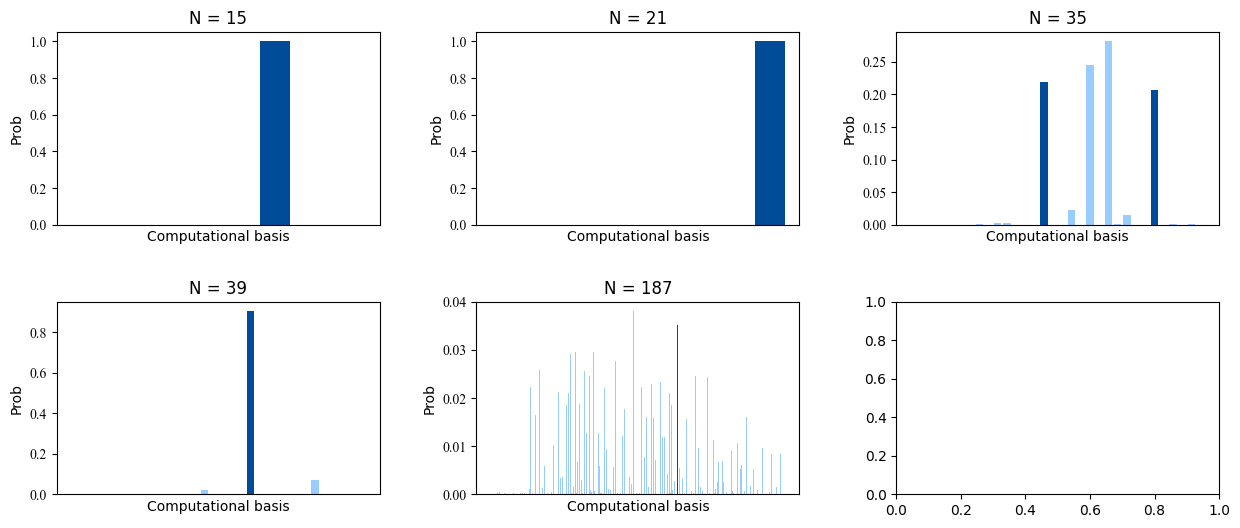

In [14]:
df = experiment_results[(experiment_results['setup']=='standard') & (experiment_results['optimizer']=='L-BFGS-B')
                        & (experiment_results['N']<=187)]
df = df.groupby(['N','layers']).last().reset_index()
Ns = sorted(df['N'].unique())

ncols = 3
nrows = math.ceil(len(Ns) / ncols)
fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols,3*nrows))
fig.subplots_adjust(hspace=0.4, wspace=0.3)
axs = axs.flatten()

for i, N in enumerate(Ns):
    df_N = df[df['N']==N].reset_index()
    idx_last_layer = df_N['layers'].idxmax()
    num_qubits = df_N.loc[idx_last_layer, 'num_qubits']
    solutions = compute_solution(N)
    x_hist = [int_to_binary_str(n, num_qubits) for n in range(2**num_qubits)]

    pops =  df_N.loc[idx_last_layer, 'state_populations']

    bar_colors = [plot_colors[1][0] if c in solutions else plot_colors[1][1] for c in x_hist]

    axs[i].bar(x_hist, pops, color=bar_colors)
    axs[i].set_ylim(0)
    axs[i].set_ylabel('Prob')
    axs[i].set_xlabel('Computational basis')

    labels = (axs[i].get_xticklabels() + axs[i].get_yticklabels())

    for label in labels:
        label.set_fontname('Times New Roman')

    axs[i].set_xticks(range(2**num_qubits), "")
    axs[i].xaxis.set_major_locator(ticker.NullLocator())
    axs[i].set_title(f'N = {N}')

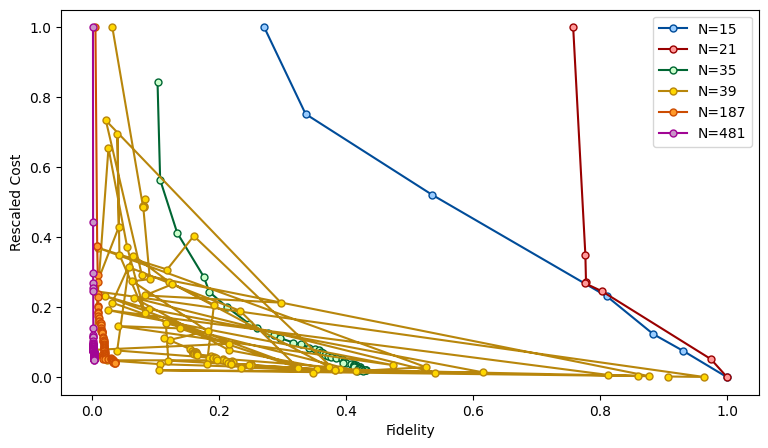

In [15]:
df = experiment_results[(experiment_results['setup']=='standard')
                        & (experiment_results['optimizer']=='L-BFGS-B')
                        & (experiment_results['N']!=119)]
df = df.groupby(['N','layers']).last().reset_index()
Ns = sorted(df['N'].unique())

fig = plt.figure(figsize=(9,5))

for i, N in enumerate(Ns):
    df_N = df[df['N']==N]
    plt.plot(df_N['fidelity'], df_N['cost_rescaled'], label=f'N={N}',
             color=plot_colors[i+1][0], mec=plot_colors[i+1][0], mfc=plot_colors[i+1][1], marker='.',
             markersize=10)

plt.xlabel('Fidelity')
plt.ylabel('Rescaled Cost')
#plt.yscale('log')
plt.legend(loc='best')
#plt.show()

# plt.savefig('../report_1/img/cost_fidelity.pdf')

In [16]:
# df = experiment_results[(experiment_results['setup']=='standard')
#                         & (experiment_results['optimizer']=='L-BFGS-B')
#                         & (experiment_results['N']>=35)
#                         & (experiment_results['N']!=119)]

# Ns = sorted(df['N'].unique())

# n_samples = 4
# fig, axs = plt.subplots(nrows=len(Ns), ncols=n_samples, figsize=(24, len(Ns)*2.8),sharex=True, sharey='row')
# fig.subplots_adjust(wspace=0.1)

# for idx_row, N in enumerate(Ns):
#     df_N = df[(df['N']==N)]

#     layer_max = df_N['layers'].max()
#     n_samples = 4
#     target_layers = [1, int(1+0.1*(layer_max-1)), int(1+0.5*(layer_max-1)), layer_max]
    
#     for idx_col, p in enumerate(target_layers):
        
#         df_p = df_N[df_N['layers']==p].copy()
#         ax = axs[idx_row][idx_col]

#         rescaled_energies_all = []
#         probs_all = []

#         for _, row in df_p.iterrows():
#             probs = row['state_populations']
#             energies = np.array(row['Ec'])

#             E_min = np.min(energies)
#             E_max = np.max(energies)
#             rescaled_E = (energies - E_min) / (E_max - E_min)

#             rescaled_energies_all.extend(rescaled_E)
#             probs_all.extend(probs)

#         # Plot using hexbin for density
#         gridsize=60 if N < 187 else 100
#         hb = ax.hexbin(rescaled_energies_all, probs_all,
#                        gridsize=gridsize, cmap='plasma', bins='log', yscale='log')
                       
#         ax.set_xlim(-0.01,1.01)
        
#         ax.set_title(f'p = {p}', fontsize='large', fontweight='medium')
#         if idx_col == 0:
#             ax.set_ylabel('$P$')
#         if idx_row == len(Ns)-1:
#             ax.set_xlabel('$\\tilde{E}$')

#         # Convert to NumPy arrays
#         rescaled_energies_all = np.array(rescaled_energies_all)
#         probs_all = np.array(probs_all)

#         x = sorted(np.unique(rescaled_energies_all))
#         y = []

#         for e in x:
#             idcs = np.where(rescaled_energies_all==e)
#             probs = probs_all[idcs]
#             y.append(np.average(probs))

#         smoothed = lowess(y, x, frac=0.1)
#         # ax.plot(smoothed[:,0], smoothed[:,1], color='green', linewidth=1)
#         # ylim = 1e-6 if N < 187 else 1e-7
#         # ax.set_ylim(ylim)

#     # Get vertical center of any subplot in the row (e.g., first column)
#     ax_row = axs[idx_row][0]
#     pos = ax_row.get_position()
#     y_center = (pos.y0 + pos.y1) / 2

#     # Add label to the left of the row
#     fig.text(0.08, y_center, f'N={N}', va='center', ha='right', fontsize='large', fontweight='medium', rotation=90)


# # Color bar for density
# fig.colorbar(hb, ax=axs, label='log(count)', shrink=0.4)

# # plt.show()

# # plt.savefig('../report_1/img/prob_eigenstates.pdf')

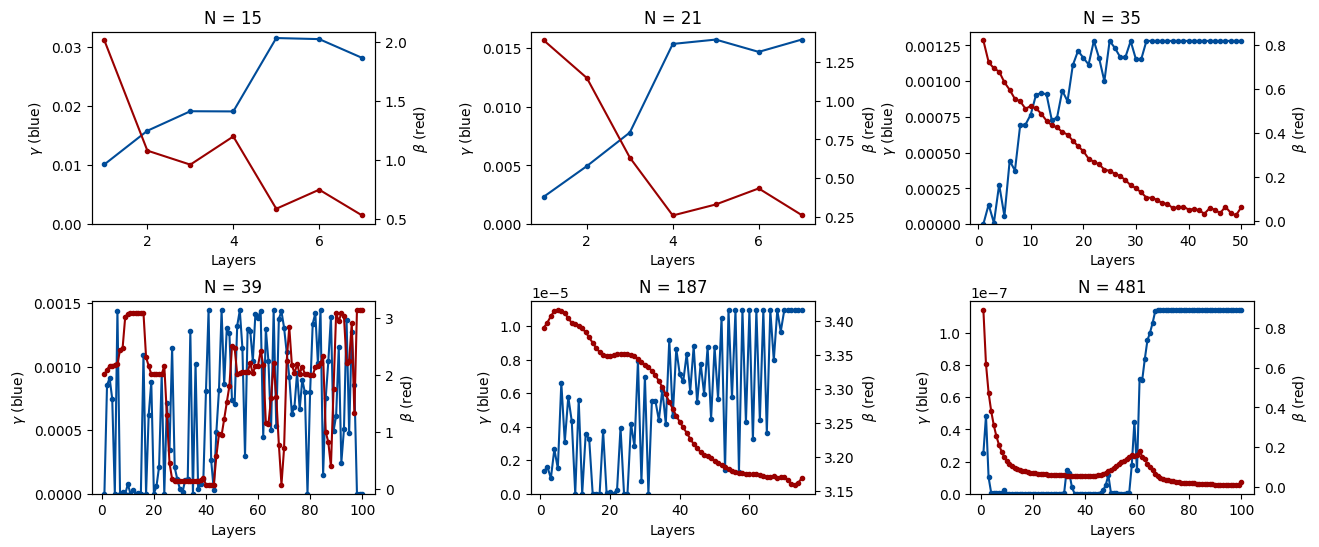

In [17]:
df = experiment_results[(experiment_results['setup']=='standard')
                        & (experiment_results['optimizer']=='L-BFGS-B')
                        & (experiment_results['N']!=119)]
df = df.groupby(['N','layers']).last().reset_index()

Ns = sorted(df['N'].unique())
optimizers = sorted(experiment_results['optimizer'].unique())

ncols = 3
nrows = math.ceil(len(Ns) / ncols)
fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols,3*nrows))
fig.subplots_adjust(hspace=0.4, wspace=0.55)
axs = axs.flatten()
for i, N in enumerate(Ns):
    df_N = df[df['N']==N].reset_index()
    idx_last_layer = df_N['layers'].idxmax()
    layers = df_N.loc[idx_last_layer, 'layers']
    gammas =  df_N.loc[idx_last_layer, 'gammas']
    betas = df_N.loc[idx_last_layer, 'betas']

    ax1 = axs[i]
    ax2 = ax1.twinx()

    ax1.plot(range(1,layers+1), gammas, marker='.', color=plot_colors[1][0])
    ax1.set_ylabel('$\\gamma$ (blue)')

    ax2.plot(range(1,layers+1), betas, marker='.', color=plot_colors[2][0])
    ax2.set_ylabel('$\\beta$ (red)')
    
    axs[i].set_xlabel('Layers')
    axs[i].set_ylim(0)
    axs[i].set_title(f'N = {N}')

for j in range(len(Ns), len(axs)):
    axs[j].remove()

# plt.savefig('../report_1/img/angle_evolution.pdf')

### Comparing with an unbounded method (BFGS)

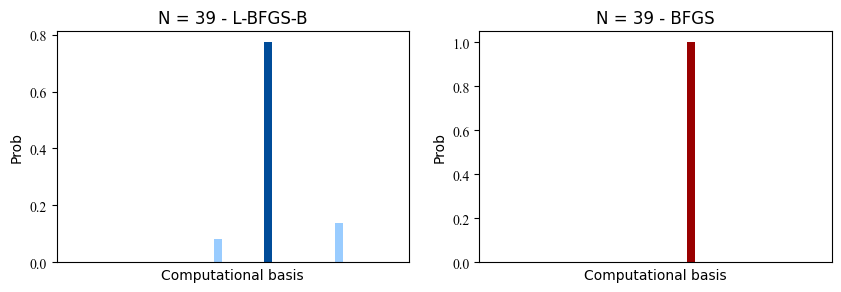

In [18]:
N = 39
gamma_0 = 0.0004
beta_0 = 0.5

df = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['setup']=='standard')
                        & (experiment_results['gamma_0']==gamma_0)
                        & (experiment_results['beta_0']==beta_0)].reset_index(drop=True)
fig, axs = plt.subplots(1, 2, figsize=(10,3))

for j, optimizer in enumerate(['L-BFGS-B', 'BFGS']):
    df_j = df[df['optimizer']==optimizer].reset_index()
    idx_last_layer = df_j['layers'].idxmax()
    num_qubits = df_j.loc[idx_last_layer, 'num_qubits']
    solutions = compute_solution(N)
    x_hist = [int_to_binary_str(n, num_qubits) for n in range(2**num_qubits)]

    pops =  df_j.loc[idx_last_layer, 'state_populations']

    bar_colors = [plot_colors[j+1][0] if c in solutions else plot_colors[j+1][1] for c in x_hist]

    axs[j].bar(x_hist, pops, color=bar_colors)
    axs[j].set_ylim(0)
    axs[j].set_ylabel('Prob')

    labels = (axs[j].get_xticklabels() + axs[j].get_yticklabels())

    for label in labels:
        label.set_fontname('Times New Roman')

    axs[j].set_xticks(range(2**num_qubits), "")
    axs[j].xaxis.set_major_locator(ticker.NullLocator())
    axs[j].set_title(f'N = {N} - {optimizer}')

    if i == len(Ns)-1:
        axs[j].set_xlabel('Computational basis')

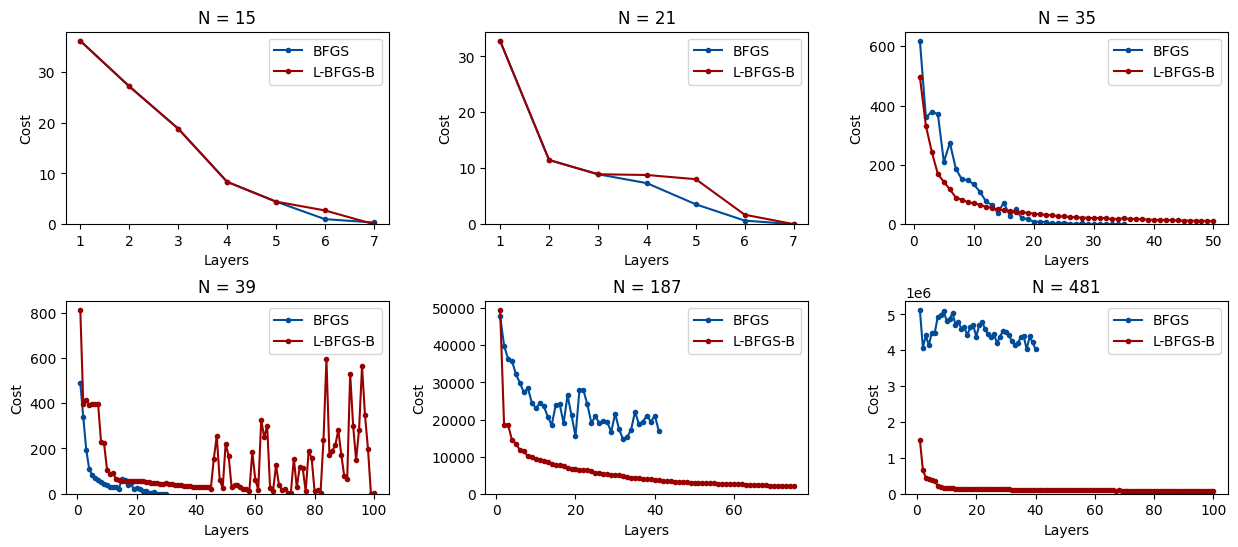

In [19]:
df = experiment_results[(experiment_results['setup']=='standard')&(experiment_results['N']!=119)]
df = df.groupby(['N','layers', 'optimizer']).last().reset_index()

Ns = sorted(df['N'].unique())
optimizers = ['BFGS', 'L-BFGS-B']
setups = sorted(experiment_results['setup'].unique(), reverse=True)

ncols = 3
nrows = math.ceil(len(Ns) / ncols)
fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols,3*nrows))
fig.subplots_adjust(hspace=0.4, wspace=0.3)
axs = axs.flatten()
for i, N in enumerate(Ns):
    for j, optimizer in enumerate(optimizers):
        df_N = df[(df['N']==N) & (df['optimizer']==optimizer)]
        axs[i].plot('layers', 'cost', data=df_N, marker='.', label=optimizer, color=plot_colors[j+1][0])
    
    axs[i].set_ylabel('Cost')
    axs[i].set_xlabel('Layers')
    axs[i].set_ylim(0)
    axs[i].set_title(f'N = {N}')
    axs[i].legend(loc='best')

for j in range(len(Ns), len(axs)):
    axs[j].remove()

# plt.savefig('../report_1/img/unbounded_cost_evolution.pdf')

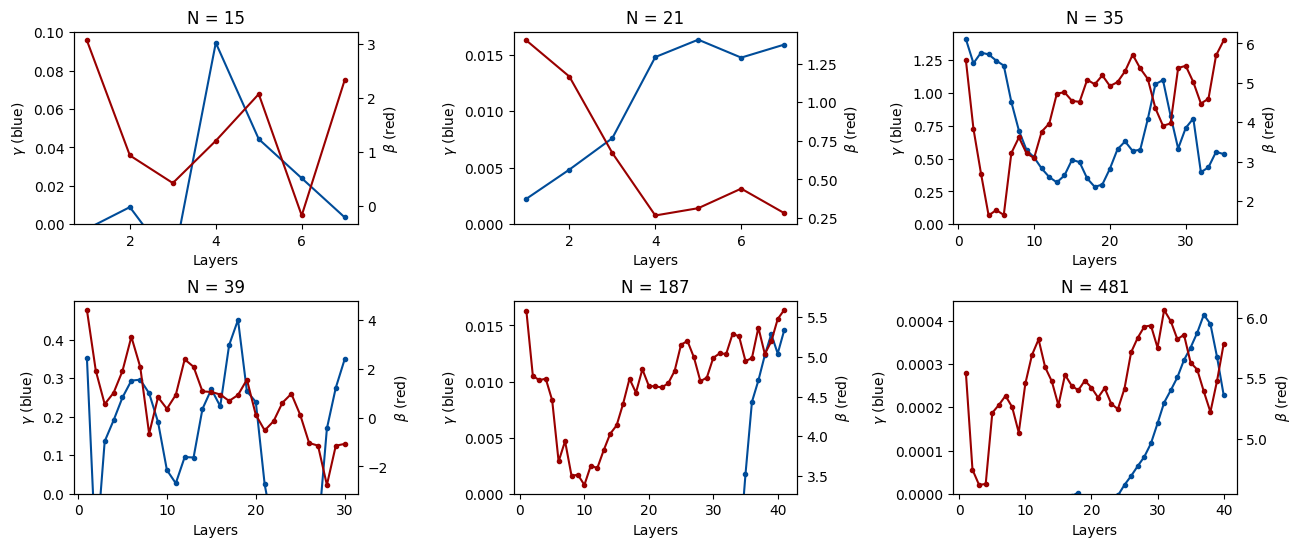

In [20]:
df = experiment_results[(experiment_results['setup']=='standard')
                        & (experiment_results['optimizer']=='BFGS')
                        & (experiment_results['N']!=119)]
df = df.groupby(['N','layers']).last().reset_index()

Ns = sorted(df['N'].unique())
optimizers = sorted(experiment_results['optimizer'].unique())

ncols = 3
nrows = math.ceil(len(Ns) / ncols)
fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols,3*nrows))
fig.subplots_adjust(hspace=0.4, wspace=0.55)
axs = axs.flatten()
for i, N in enumerate(Ns):
    df_N = df[df['N']==N].reset_index()
    idx_last_layer = df_N['layers'].idxmax()
    layers = df_N.loc[idx_last_layer, 'layers']
    gammas =  df_N.loc[idx_last_layer, 'gammas']
    betas = df_N.loc[idx_last_layer, 'betas']

    ax1 = axs[i]
    ax2 = ax1.twinx()

    ax1.plot(range(1,layers+1), gammas, marker='.', color=plot_colors[1][0])
    ax1.set_ylabel('$\\gamma$ (blue)')

    ax2.plot(range(1,layers+1), betas, marker='.', color=plot_colors[2][0])
    ax2.set_ylabel('$\\beta$ (red)')
    
    axs[i].set_xlabel('Layers')
    axs[i].set_ylim(0)
    axs[i].set_title(f'N = {N}')

for j in range(len(Ns), len(axs)):
    axs[j].remove()

# plt.savefig('../report_1/img/angle_evolution_unbounded.pdf')